## Padding填充

#### Zero padding
就是把边缘设置成0，成黑色

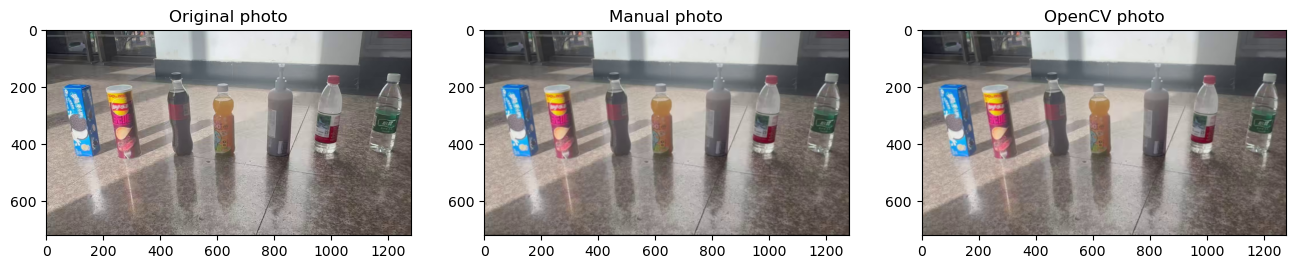

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x*x + y*y) / (2 * sigma * sigma))
    kernel /= np.sum(kernel)
    return kernel

def conv_color(image, kernel):
    h, w, c = image.shape
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2

    padded = np.zeros((h + 2*pad_h, w + 2*pad_w, c), dtype=np.float32)
    padded[pad_h:pad_h+h, pad_w:pad_w+w, :] = image.astype(np.float32)

    result = np.zeros_like(image, dtype=np.float32)

    for y in range(h):
        for x in range(w):
            for ch in range(c):
                region = padded[y:y+kh, x:x+kw, ch]
                result[y, x, ch] = np.sum(region * kernel)

    return np.clip(result, 0, 255).astype(np.uint8)


image = cv2.imread("raw.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

kernel = gaussian_kernel(7, 1.2)

filtered_manual = conv_color(image, kernel)
filtered_cv = cv2.GaussianBlur(image, (7, 7), 1.2)

plt.figure(figsize=(16,7))
plt.subplot(131), plt.imshow(image), plt.title("Original photo")
plt.subplot(132), plt.imshow(filtered_manual), plt.title("Manual photo")
plt.subplot(133), plt.imshow(filtered_cv), plt.title("OpenCV photo")
plt.show()


#### mirror padding
在 OpenCV 和深度学习框架中，这种 padding 模式通常称为 cv2.BORDER_REFLECT_101。

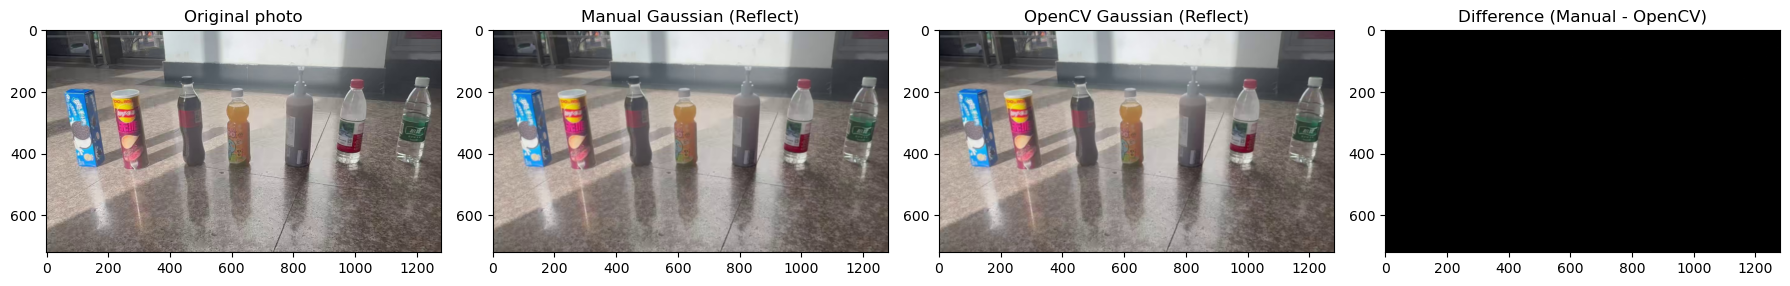

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x*x + y*y) / (2 * sigma * sigma))
    kernel /= np.sum(kernel)
    return kernel

def reflect_pad_index(idx, size):
    if idx < 0:
        return -idx - 1
    elif idx >= size:
        return 2 * size - idx - 1
    else:
        return idx

def conv_color_reflect(image, kernel):
    h, w, c = image.shape
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2

    result = np.zeros_like(image, dtype=np.float32)

    for y in range(h):
        for x in range(w):
            for ch in range(c):
                val = 0.0
                for ky in range(kh):
                    for kx in range(kw):
                        
                        iy = y + ky - pad_h
                        ix = x + kx - pad_w
                        iy_ref = reflect_pad_index(iy, h)
                        ix_ref = reflect_pad_index(ix, w)

                        val += image[iy_ref, ix_ref, ch] * kernel[ky, kx]
                result[y, x, ch] = val

    return np.clip(result, 0, 255).astype(np.uint8)

image = cv2.imread("raw.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

kernel = gaussian_kernel(7, 1.2)

filtered_manual = conv_color_reflect(image, kernel)
filtered_cv = cv2.GaussianBlur(image, (7, 7), 1.2, borderType=cv2.BORDER_REFLECT_101)

plt.figure(figsize=(18, 6))
plt.subplot(141), plt.imshow(image), plt.title("Original photo")
plt.subplot(142), plt.imshow(filtered_manual), plt.title("Manual Gaussian (Reflect)")
plt.subplot(143), plt.imshow(filtered_cv), plt.title("OpenCV Gaussian (Reflect)")
plt.subplot(144), plt.imshow(np.abs(filtered_manual.astype(np.float32) - filtered_cv.astype(np.float32)).astype(np.uint8)), 
plt.title("Difference (Manual - OpenCV)")
plt.tight_layout()
plt.show()